In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import datetime
import pandas as pd
from scipy.signal import argrelextrema
#import statistics
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
data_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmed_fn = "time_series_covid19_confirmed_global.csv"
deaths_fn = "time_series_covid19_deaths_global.csv"
recovered_fn = "time_series_covid19_recovered_global.csv"

In [96]:
#get files with data
import requests

def get_raw_from_git(link, filename, verbose=True):
    r = requests.get(link + filename)
    if verbose:
        if (r.status_code == requests.codes.ok):
            print(filename + " done")
        else:
            print(filename + " failed to get raw")
            return
    open(filename , 'wb').write(r.content)
    

get_raw_from_git(data_link, confirmed_fn)
get_raw_from_git(data_link, deaths_fn)
get_raw_from_git(data_link, recovered_fn)

#or just clone from here: https://github.com/CSSEGISandData/COVID-19

time_series_covid19_confirmed_global.csv done
time_series_covid19_deaths_global.csv done
time_series_covid19_recovered_global.csv done


### Notes

lists:
* confirmed - cumulative total confirmed cases
* deaths - cumulative deaths
* recovered - cumulative recovered


* d_infected - dI/dt, new daily confirmed cases
* d_recovered - dR/dt, new daily recovered
* removed = recovered + deaths
* Infected = confirmed - recovered

Constants:
* Nation - size of population
* removal_rate - γ
* infication_rate - β
***
<img src="SIR_reminder.svg" align="left" title="SIR_reminder"/>

In [3]:
#get lists with data from files
def get_data_list(filename, country="Ukraine"):
    df = pd.read_csv(filename, header = 0)
    dates = [datetime.datetime.strptime(i, "%m/%d/%y") for i in df.columns[4:]]
    datalist = df.loc[df['Country/Region'] == country].values.tolist()[0][4:]
    datalist = np.array(datalist, dtype=np.float64)
    return(datalist, dates)
    
confirmed, dates = get_data_list(confirmed_fn)   
deaths = get_data_list(deaths_fn)[0]
recovered = get_data_list(recovered_fn)[0]

#skip first N days where there were no cases
days_to_skip = len([i for i in confirmed if i<2])
print("days_to_skip =", days_to_skip)

dates = dates[days_to_skip:]
confirmed = confirmed[days_to_skip:]
deaths = deaths[days_to_skip:]
recovered = recovered[days_to_skip:]

#creating lists for SIR model
removed = recovered + deaths
infected = confirmed - removed

d_confirmed = np.diff(confirmed, prepend=confirmed[0])
d_infected = np.diff(infected, prepend=infected[0])
d_removed = np.diff(removed, prepend=removed[0])

days_to_skip = 51


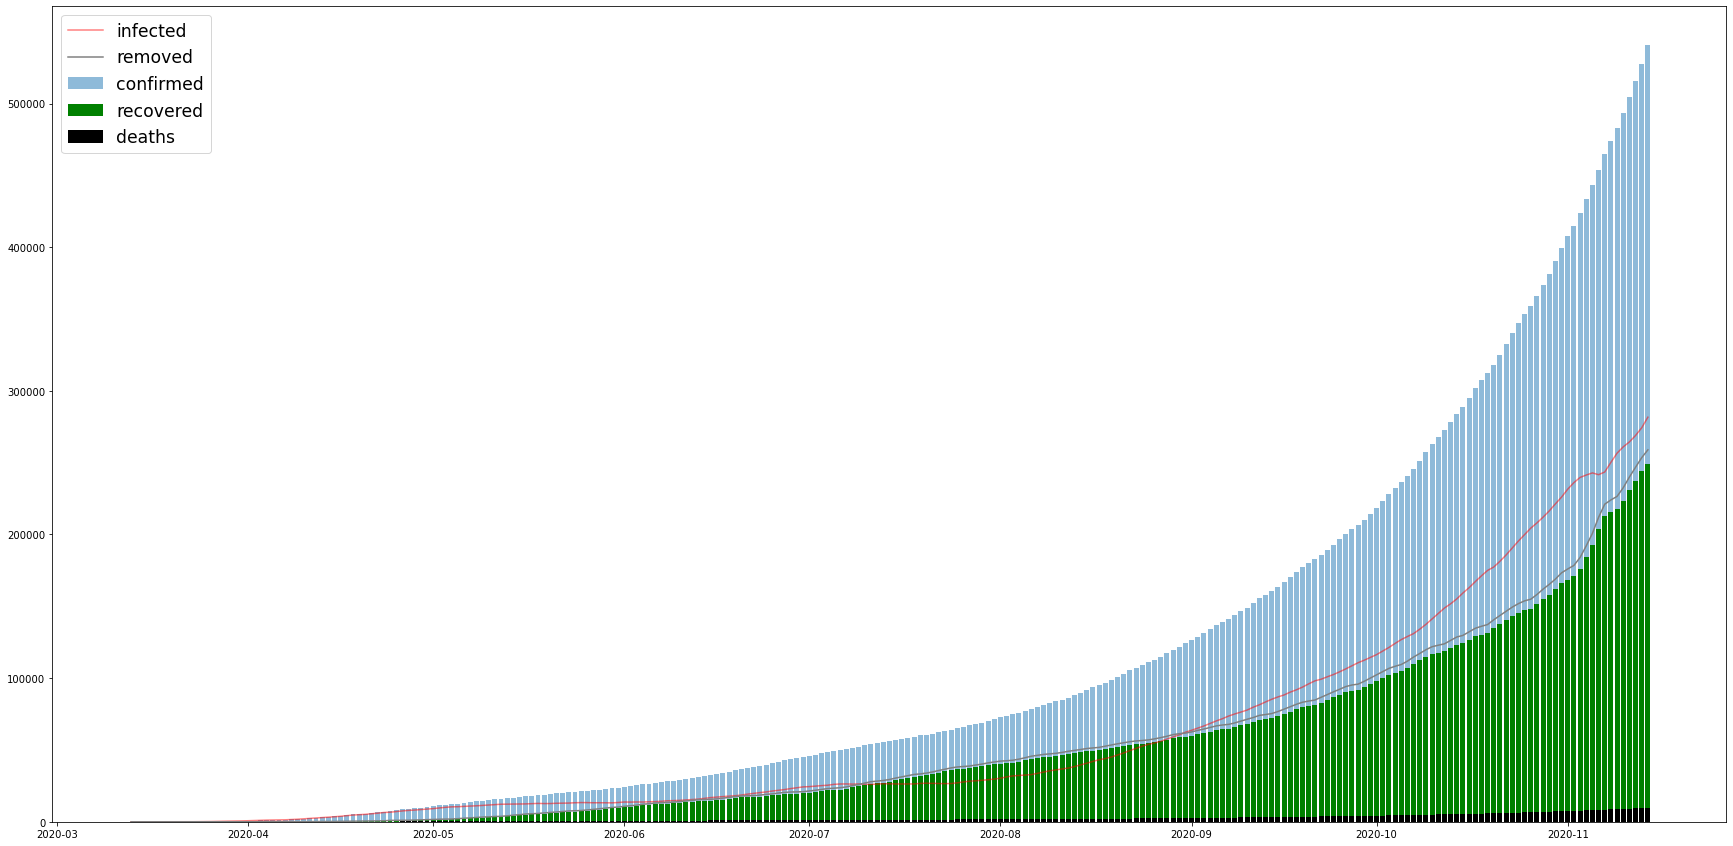

In [4]:
#visual check of imported data

plt.rcParams["figure.figsize"] = [30,15]
fig = plt.figure()

plt.bar(dates, confirmed, alpha=0.5, label="confirmed")
plt.plot(dates, infected, color="red", alpha=0.5, label="infected")
plt.plot(dates, removed, color="gray", label="removed")
plt.bar(dates, recovered, color="green", label="recovered")
plt.bar(dates, deaths, color="black", label="deaths")
plt.legend(fontsize="xx-large")

plt.show()

removal_rate (γ) = 0.018
removal_rate std = 0.011
days in infected (1/γ) = 56.9


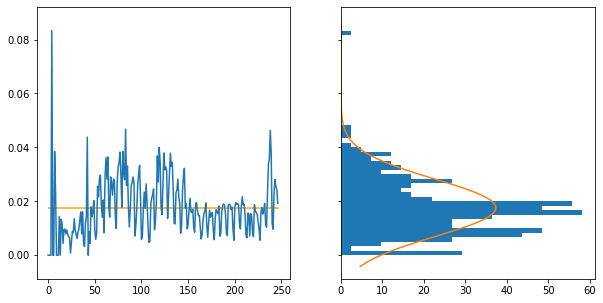

In [6]:
#let's find removal_rate(γ)
removal_rate_arr = d_removed / infected

#fit normal distribution
removal_rate, removal_rate_std = norm.fit(removal_rate_arr)

print("removal_rate (γ) =", round(removal_rate, 3))
print("removal_rate std =", round(removal_rate_std, 3))
print("days in infected (1/γ) =",  round(1/removal_rate, 1))

plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(removal_rate_arr)
ax1.hlines(removal_rate,0,len(removal_rate_arr),color="orange")

ax2.hist(removal_rate_arr, bins=50, density=True, orientation="horizontal")

xmin, xmax = ax2.get_ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, removal_rate, removal_rate_std)
ax2.plot(p, x)

plt.show()

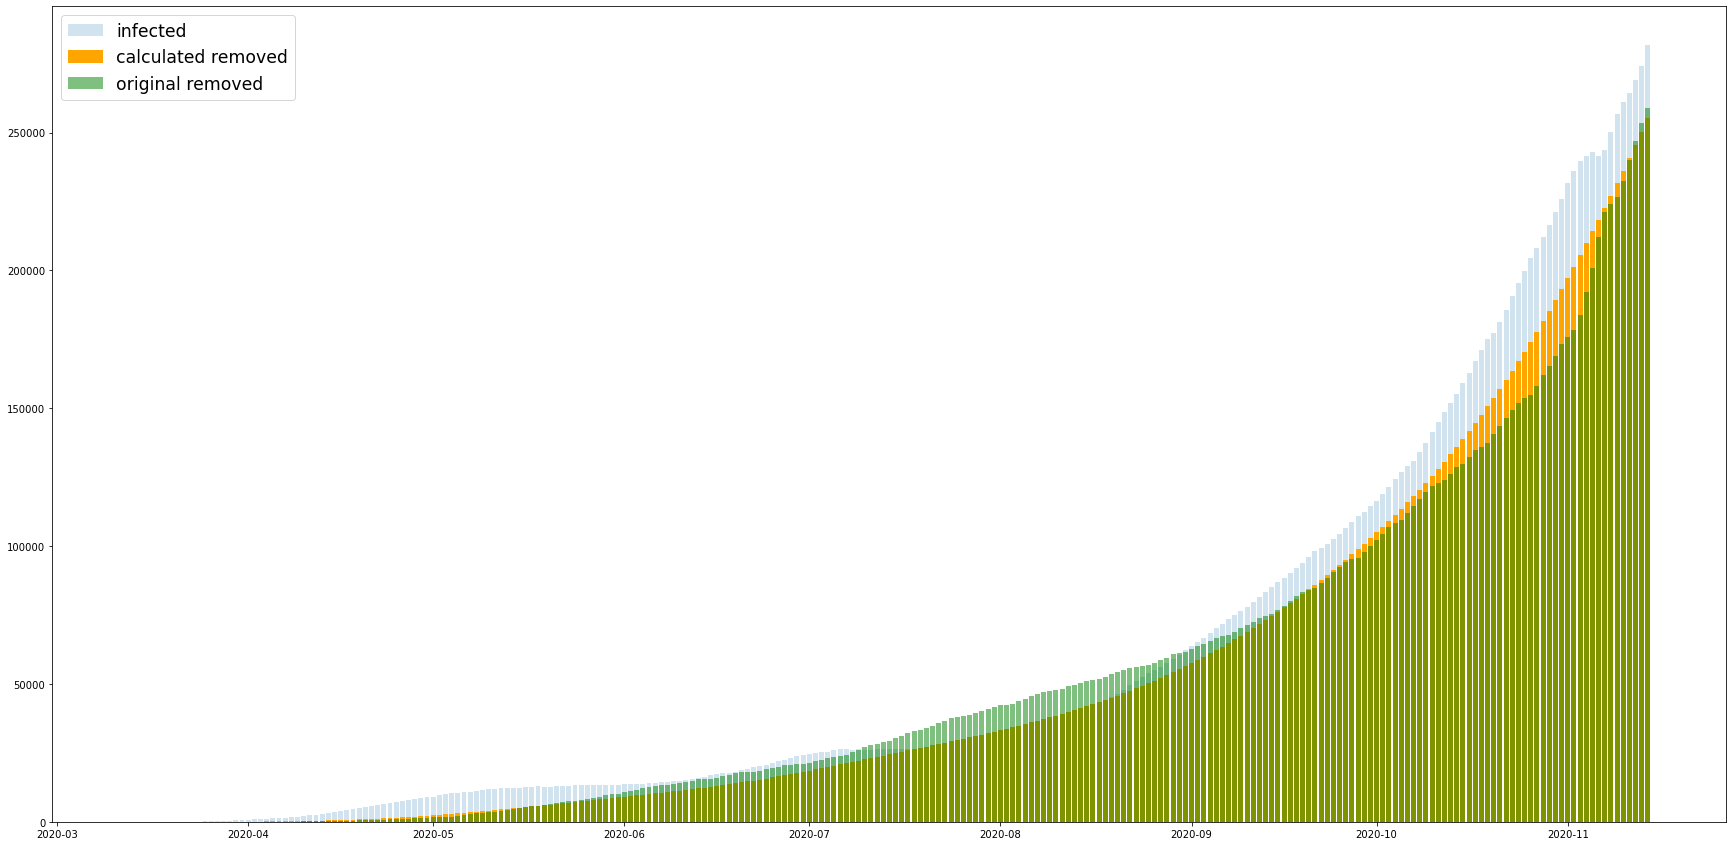

In [7]:
#visual check of calculated vs real removed values

calculated_removed = np.cumsum(removal_rate*infected)

plt.rcParams["figure.figsize"] = [30,15]
fig = plt.figure()

plt.bar(dates, infected, alpha=0.2, label="infected")
plt.bar(dates, calculated_removed, color="orange", label="calculated removed")
plt.bar(dates, removed, color="green", alpha=0.5, label="original removed")
plt.legend(fontsize="xx-large")

plt.show()

infication_rate (β) mu = 0.06
infication_rate_std = 0.081
infication_rate mode (β) = 0.033


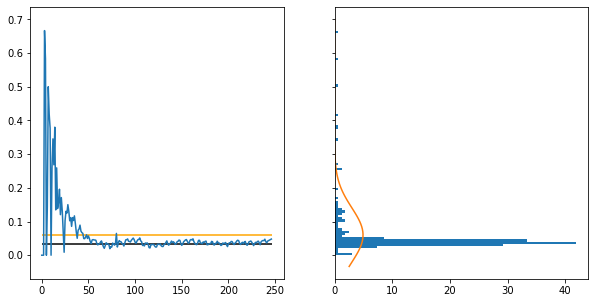

In [9]:
#https://index.minfin.com.ua/ua/reference/people/
#Nation = 41724000 #original minfin value

Nation = 10000000

infication_rate_arr = (Nation * (d_infected + d_removed)) / (infected * (Nation - infected - removed))

infication_rate, infication_rate_std = norm.fit(infication_rate_arr)
print("infication_rate (β) mu =", round(infication_rate, 3))
print("infication_rate_std =", round(infication_rate_std, 3))

plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(infication_rate_arr)
a = ax2.hist(infication_rate_arr, bins=100, density=True, orientation="horizontal")
max_pos = [i for i, j in enumerate(a[0]) if j == max(a[0])][0]
mode = a[1][max_pos]
print("infication_rate mode (β) =", round(mode, 3))

ax1.hlines(mode, 0, len(infication_rate_arr))
ax1.hlines(infication_rate, 0, len(infication_rate_arr), color="orange")

xmin, xmax = ax2.get_ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, infication_rate, infication_rate_std)
ax2.plot(p, x)

plt.show()

[0.26220761 0.03966821 0.03265473]


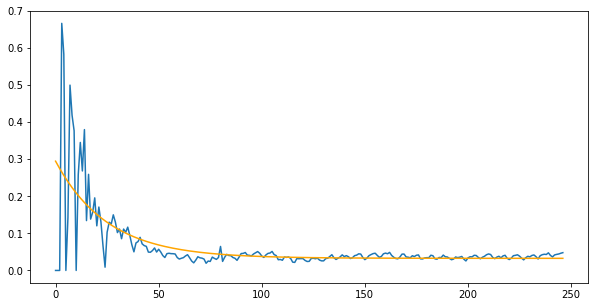

In [11]:
#approximate B as a function of time

def infication_rate_of_time(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.arange(len(infication_rate_arr))

inf_r_opt_coef, pcov = curve_fit(infication_rate_of_time,
                                 x,
                                 infication_rate_arr,
                                 bounds=([0, 0, mode-0.1], [1., 1., mode+0.1]))
print(inf_r_opt_coef)

inf_r_opt_curve = infication_rate_of_time(x, *inf_r_opt_coef)

plt.rcParams["figure.figsize"] = [10,5]
fig = plt.figure()

plt.plot(infication_rate_arr)
plt.plot(inf_r_opt_curve, color="orange")

plt.show()

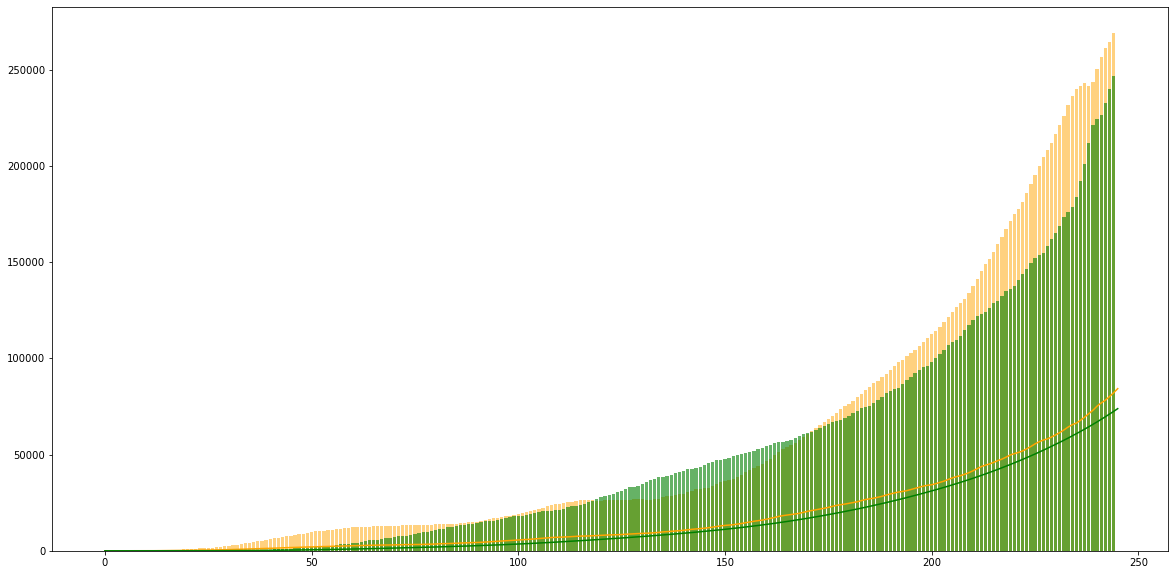

In [23]:
#reproduction_rate = estim_infication_rate / estim_removal_rate
#print("reproduction_rate =", reproduction_rate)

I = [confirmed[0]]
S = [Nation-I[0]]
R = [0]
days = np.arange(245)

for t in days:
    dr = int(removal_rate*I[-1])
    ds = math.ceil((infication_rate_of_time(t, *inf_r_opt_coef)) * S[-1] * I[-1] / Nation)
    #ds = math.ceil((infication_rate_arr[t]) * S[-1] * I[-1] / Nation)
    S.append(S[-1] - ds)
    I.append(I[-1] + ds - dr)
    R.append(R[-1] + dr)
    
plt.rcParams["figure.figsize"] = [20,10]
fig = plt.figure()

#plt.plot(S)
plt.plot(I, color="orange")
plt.plot(R, color="green")

plt.bar(days[:len(infected[:len(days)])], infected[:len(days)], color="orange", alpha=0.5)
plt.bar(days[:len(removed[:len(days)])], removed[:len(days)], color="green", alpha=0.6)

plt.show()

In [13]:
infected[0]

2.0